## Fashion MNIST

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The dataset serves as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.


## Loading the packages

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import utils

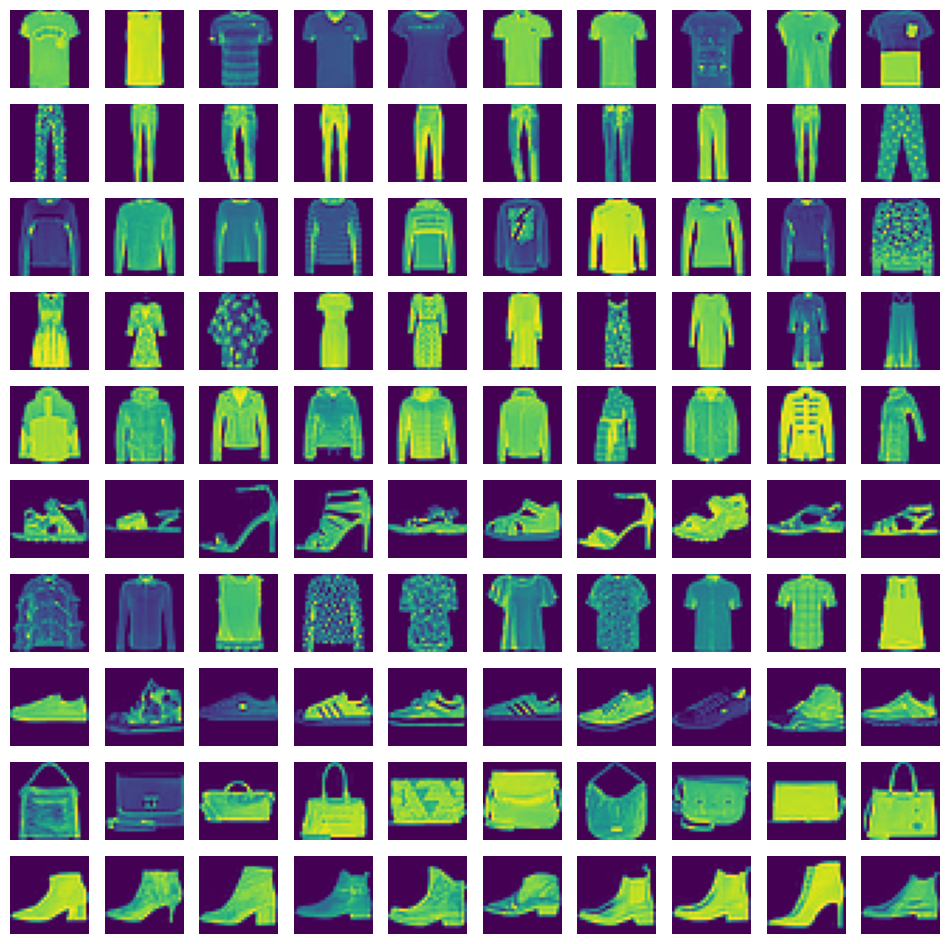

training input shape :  (60000, 28, 28)
training output shape:  (60000,)
testing input shape  :  (10000, 28, 28)
testing output shape :  (10000,)


In [2]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval. Previously, for instance, the training data were stored in an array of shape (60000, 28, 28) of type uint8 with values in the \[0, 255\] interval. We transform it into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1.

In [3]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [4]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(y_train[:10])
print(Y_train[:10])

[9 0 0 3 0 2 7 2 5 5]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


### CNN with 1 conv layer

We will build a CNN that takes as input tensors of shape *(image_height, image_width, image_channels)*. In this case, inputs are of size (28, 28, 1), which is the format of the FashionMNIST images with only one gray channel.

- The 1st layer is a Conv2D layer for the **convolution** operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map. Here we choose filters with size 3 x 3. The first layer must also specify the size of the input with `input_shape=(28, 28, 1)`. This layer is followed by an activation layer 'relu'.
- The next layer is a MaxPooling2D layer for the **max-pooling** operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. Here we choose the pooling window with size 2 x 2.
- To "fight" overfitting, we may add a Dropout layer as the 3rd layer. **Dropout** is a powerful regularization technique used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. In this model, we can specify the quantity of neurons that we will randomnly disable, e.g. 20%. The dropout layer does not change the dimension of the data.
- The next step is to feed the last output tensor into one or several Dense layers, otherwise known as **fully-connected** layers. These densely connected classifiers takes as input vectors that are 1D. In our case, the output of the conv-relu-pool-dropout layers is a 3D tensor (13, 13, 32). Thus, we need to flatten the 3D outputs to 1D using a Flatten layer. Finally we can add 2 Dense layers on top.
- As there are 10 classes in FashionMNIST, the final layer has 10 neurons for which we select a softmax activation. **Softmax activation** enables to estimate class posterior probabilities. The winner class is the one with the highest posterior probability.

The `summary()` methods prints out the structure of the network created with the sequential model.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn1 = Sequential()

cnn1.add(InputLayer(shape=(28, 28, 1)))
cnn1.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(10, activation='softmax'))

cnn1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,554 (3.07 MB)

 Trainable params: 804,554 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model
When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training.

- We choose here `categorical_crossentropy` as the loss function. This loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- We chose here the `adam` optimizer. The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [10]:
cnn1.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['accuracy'])

#### Training the model
We can now train the model. We need to select the batch size and the number of epochs. In this case we can set it to batches of 256 with 10 epochs. We also need to pass in the training and validation data.

In [11]:
log = cnn1.fit(X_train, Y_train,
          batch_size=256,
          epochs=20,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7473 - loss: 0.7241 - val_accuracy: 0.8602 - val_loss: 0.3895
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8758 - loss: 0.3560 - val_accuracy: 0.8787 - val_loss: 0.3364
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8929 - loss: 0.3028 - val_accuracy: 0.8898 - val_loss: 0.3039
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9042 - loss: 0.2668 - val_accuracy: 0.8958 - val_loss: 0.2810
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9111 - loss: 0.2432 - val_accuracy: 0.8988 - val_loss: 0.2746
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9198 - loss: 0.2235 - val_accuracy: 0.8989 - val_loss: 0.2778
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9215 - loss: 0.2124 - val_accuracy: 0.9070 - val_loss: 0.2569
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9286 - loss: 0.1982 - val_accu

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

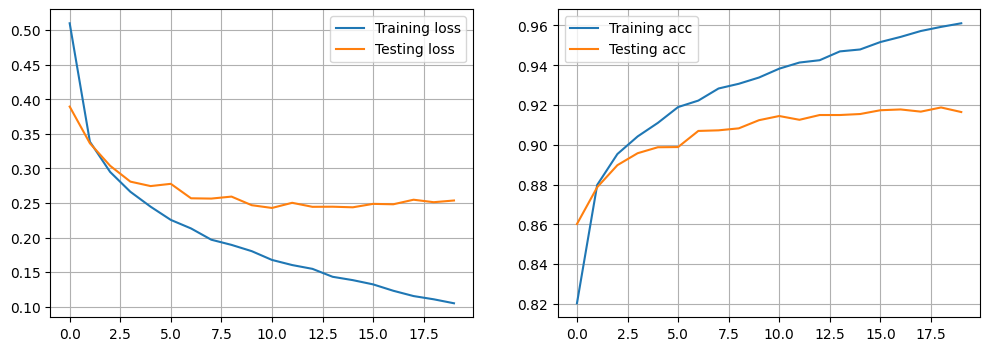

In [12]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [13]:
loss_test, metric_test = cnn1.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9157 - loss: 0.2614 
Test loss: 0.25372982025146484
Test accuracy: 0.9164999723434448


### Improving the model

As seen in the previous exercises, we may improve the model performances by stacking CONV-RELU-POOL layers and playing with the different hyper-parameters of the different layers: number of filters, kernel size, etc.

```python
# add blocks such as these one below to increase the depth
cnn1.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))
```

## Visualizing What My Model Learns

It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts.
Here I attempt to visualize the intermediate CNN outputs (intermediate activations). Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network.
I want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

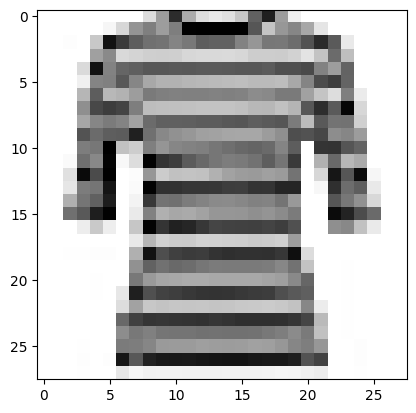

(28, 28, 1)

In [20]:
test_im1 = X_train[26]
plt.imshow(test_im1.reshape(28,28), cmap='Greys', 
           interpolation='none')
plt.show()
test_im1.shape

In order to extract the feature maps I want to look at, I create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, I use the Keras class Model. A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class is a Keras model, mapping the specified inputs to the specified outputs. When fed an image input, this model returns the values of the layer activations in the original model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
(1, 28, 28, 32)


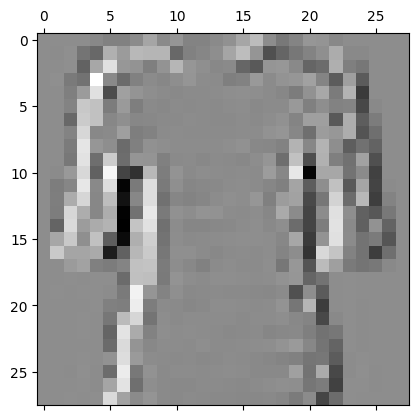

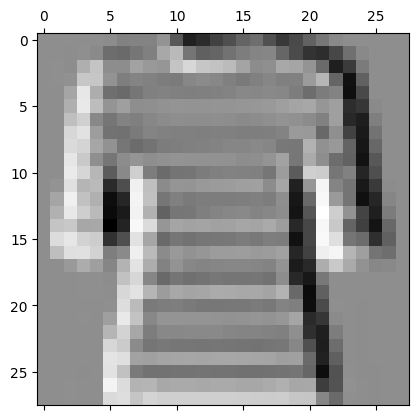

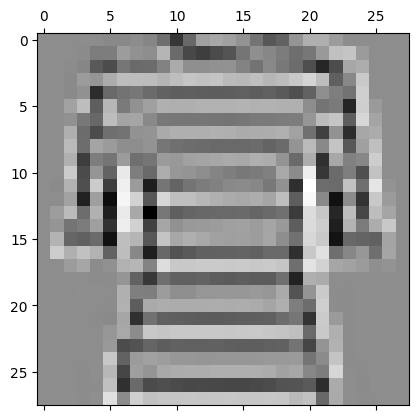

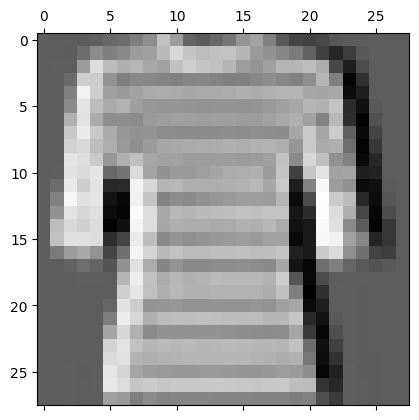

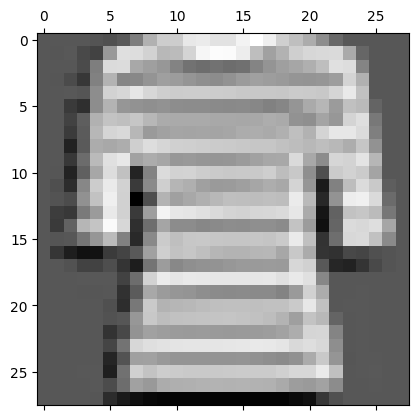

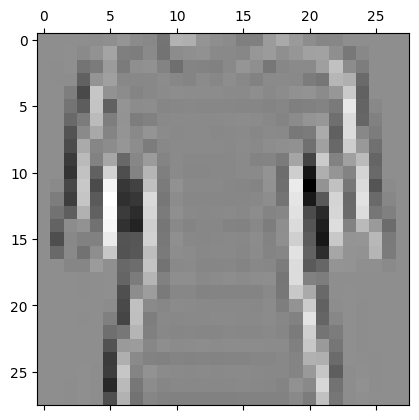

In [27]:
from tensorflow.keras import models
# extracts the output of the first CNN layer
layer_input = cnn1.layers[0].input
layer_1st_conv = cnn1.layers[0].output

# creates a model able to return these outputs, given an input
activation_model = models.Model(inputs=layer_input, 
                                outputs=layer_1st_conv)

# we need to reshape the image (28,28,1) into (1,28,28,1)
# as the network expect a batch of images as input
test_im1 = test_im1.reshape(1,28,28,1)

# returns the first layer activation
first_layer_activation = activation_model.predict(test_im1)
print(first_layer_activation.shape)

# display 6 of the activations of the 1st conv layer
plt.matshow(first_layer_activation[0, :, :, 0], cmap='Greys')
plt.matshow(first_layer_activation[0, :, :, 1], cmap='Greys')
plt.matshow(first_layer_activation[0, :, :, 2], cmap='Greys')
plt.matshow(first_layer_activation[0, :, :, 3], cmap='Greys')
plt.matshow(first_layer_activation[0, :, :, 4], cmap='Greys')
plt.matshow(first_layer_activation[0, :, :, 5], cmap='Greys')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


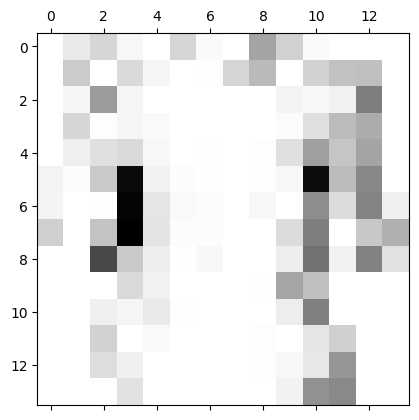

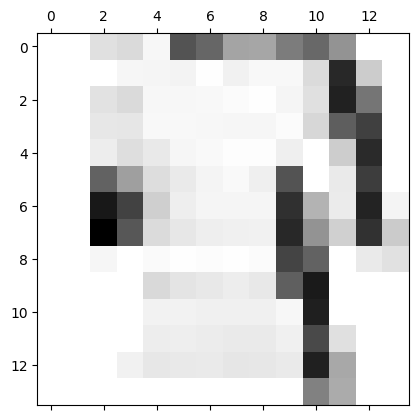

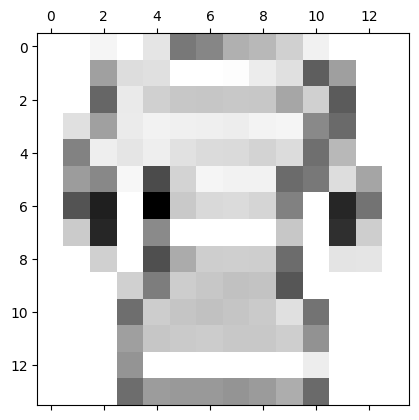

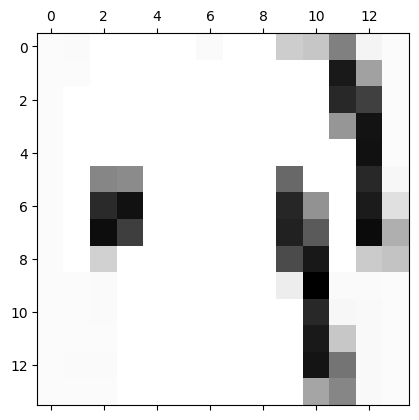

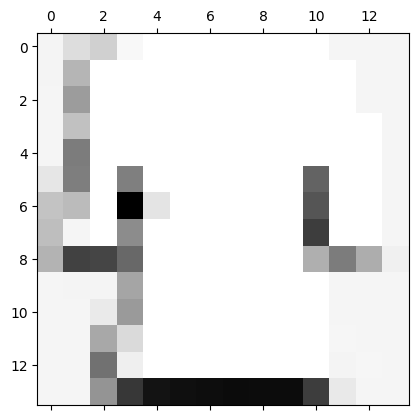

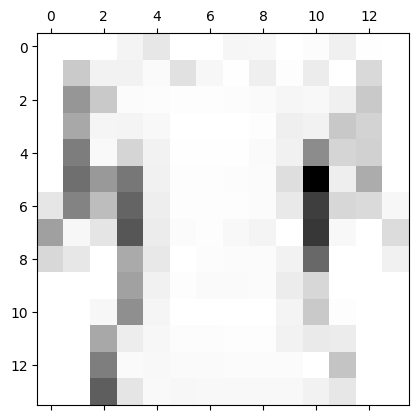

In [28]:
from tensorflow.keras import models
# extracts the output of the first layer
layer_1st_maxpool = cnn1.layers[2].output

# creates a model able to return these outputs, given an input
activation_model = models.Model(inputs=layer_input, 
                                outputs=layer_1st_maxpool)

# we need to reshape the image (28,28,1) into (1,28,28,1)
# as the network expect a batch of images as input
test_im1 = test_im1.reshape(1,28,28,1)

# returns the first layer activation
first_maxpool_activation = activation_model.predict(test_im1)

# display 6 of the activations of the 1st conv layer
plt.matshow(first_maxpool_activation[0, :, :, 0], cmap='Greys')
plt.matshow(first_maxpool_activation[0, :, :, 1], cmap='Greys')
plt.matshow(first_maxpool_activation[0, :, :, 2], cmap='Greys')
plt.matshow(first_maxpool_activation[0, :, :, 3], cmap='Greys')
plt.matshow(first_maxpool_activation[0, :, :, 4], cmap='Greys')
plt.matshow(first_maxpool_activation[0, :, :, 5], cmap='Greys')

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomContrast
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn2 = Sequential()
cnn2.add(InputLayer(shape=(28, 28, 1)))

cnn2.add(RandomRotation(factor=0.15))
cnn2.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
cnn2.add(RandomFlip(mode='horizontal'))
cnn2.add(RandomContrast(factor=0.1))

cnn2.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(28, 28, 1)))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.2))
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(10, activation='softmax'))

cnn2.summary()
cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_4               │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_2            │ (None, 28, 28, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 28, 28, 1)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,554 (3.07 MB)

 Trainable params: 804,554 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
log = cnn2.fit(X_train, Y_train,
          batch_size=256,
          epochs=75,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5115 - loss: 1.3726 - val_accuracy: 0.7065 - val_loss: 0.7794
Epoch 2/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7119 - loss: 0.8067 - val_accuracy: 0.7290 - val_loss: 0.7483
Epoch 3/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7403 - loss: 0.7169 - val_accuracy: 0.7704 - val_loss: 0.6490
Epoch 4/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7624 - loss: 0.6619 - val_accuracy: 0.7697 - val_loss: 0.6163
Epoch 5/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7722 - loss: 0.6322 - val_accuracy: 0.7797 - val_loss: 0.6066
Epoch 6/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7821 - loss: 0.6046 - val_accuracy: 0.7996 - val_loss: 0.5620
Epoch 7/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7878 - loss: 0.5895 - val_accuracy: 0.8028 - val_loss: 0.5483
Epoch 8/75
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7918 - loss: 0.5744 - val_accu

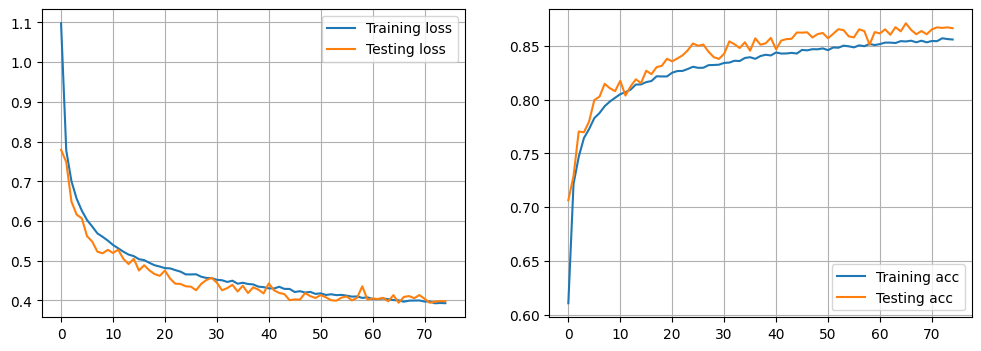

In [42]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [43]:
loss_test, metric_test = cnn2.evaluate(val_batches, verbose=1)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8452 - loss: 0.4313
Test loss: 0.42542147636413574
Test accuracy: 0.8483999967575073


It seems that CNN1, trained without data augmentation, was performing better with 91.6. We should probably here push the training of CNN2 a bit longer.

Also, if we now observe the performand of CNN1 on augmented data, we observe a drop of performance.

In [44]:
loss_test, metric_test = cnn1.evaluate(val_batches, verbose=1)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7785 - loss: 0.6998
Test loss: 0.7028456330299377
Test accuracy: 0.7754999995231628
